In [145]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

In [146]:
data_dir = 'Dataset'
classes = os.listdir(data_dir)

In [147]:
class_distribution = {}
for class_name in classes:
    class_files = os.listdir(os.path.join(data_dir, class_name))
    class_distribution[class_name] = len(class_files)

In [148]:
print("Class Distribution:")
print(class_distribution)

Class Distribution:
{'Elephant': 600, 'Leopard': 600, 'Negative': 851, 'Otter': 600, 'Tiger': 1200}


In [149]:
def visualize_audio_sample(file_path):
    audio, sr = librosa.load(file_path)
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

Sample from class Elephant:


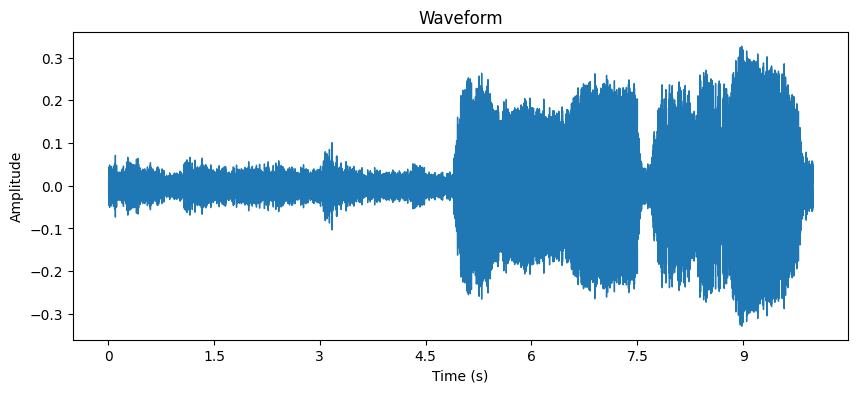

Sample from class Leopard:


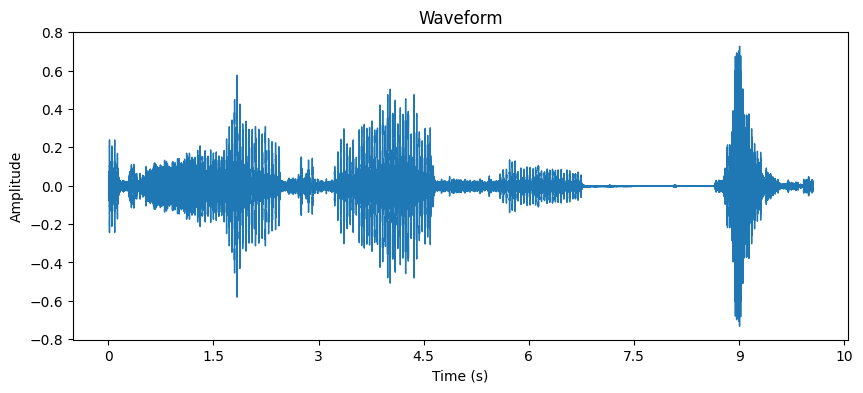

Sample from class Negative:


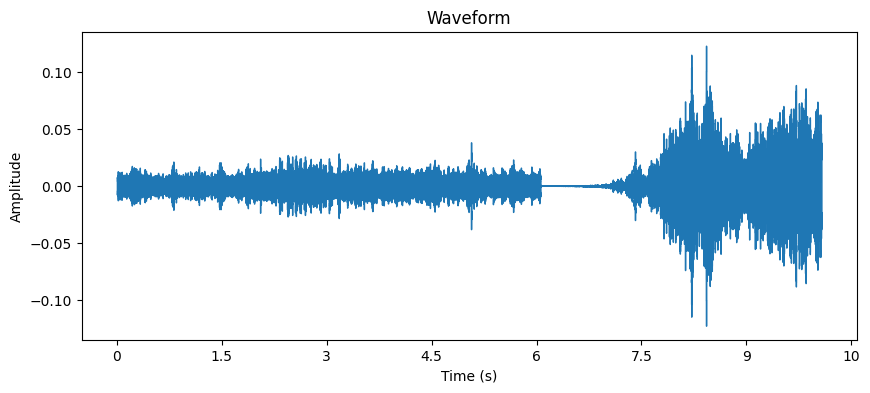

Sample from class Otter:


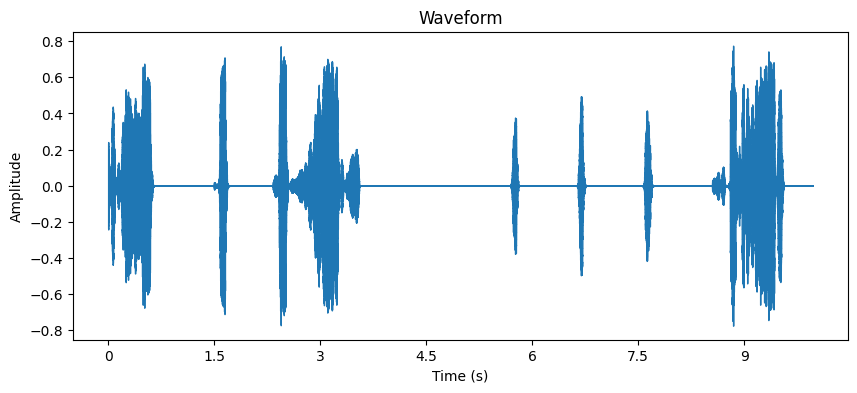

Sample from class Tiger:


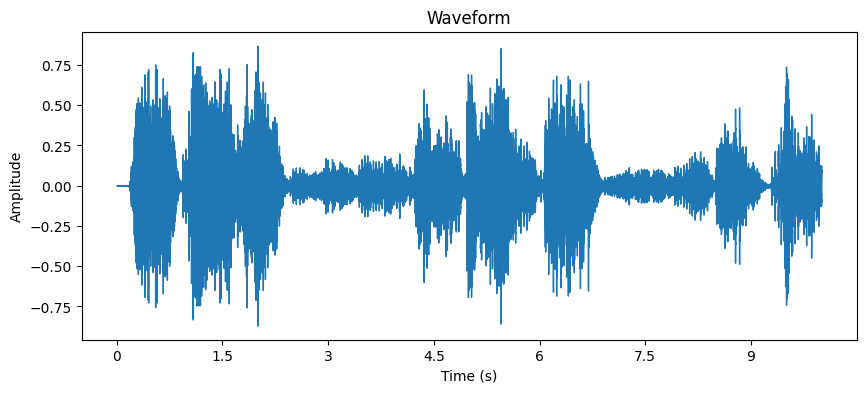

In [150]:
for class_name in classes:
    class_files = os.listdir(os.path.join(data_dir, class_name))
    sample_file = os.path.join(data_dir, class_name, class_files[0])
    print(f"Sample from class {class_name}:")
    visualize_audio_sample(sample_file)


In [151]:
def extract_features(file_path):
    audio, sr = librosa.load(file_path)
    
    # Spectrogram
    spectrogram = np.abs(librosa.stft(audio))
    
    # Spectral Rolloff
    spectral_rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr)[0]
    
    # Chroma Features
    chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
    
    # Zero Crossing Rate
    zero_crossing_rate = librosa.feature.zero_crossing_rate(y=audio)[0]
    
    return spectrogram, spectral_rolloff, chroma, zero_crossing_rate

In [152]:
sample_file = os.path.join(data_dir, classes[0], os.listdir(os.path.join(data_dir, classes[0]))[0])
spectrogram, spectral_rolloff, chroma, zero_crossing_rate = extract_features(sample_file)

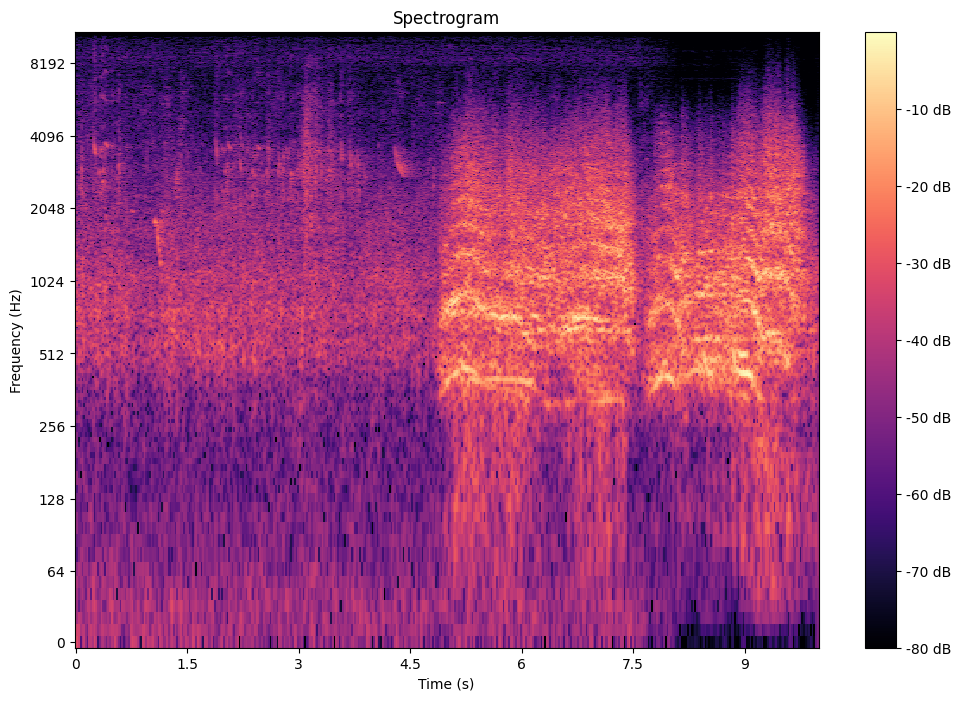

In [153]:
plt.figure(figsize=(12, 8))
librosa.display.specshow(librosa.amplitude_to_db(spectrogram, ref=np.max), y_axis='log', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.show()

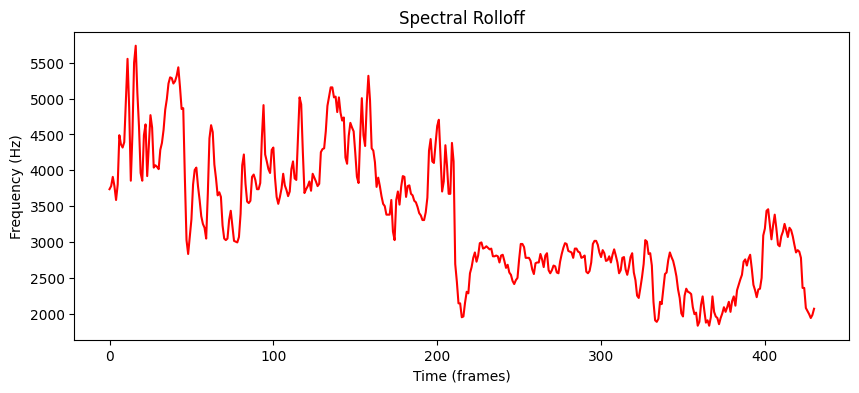

In [154]:
plt.figure(figsize=(10, 4))
plt.plot(spectral_rolloff, color='r')
plt.title('Spectral Rolloff')
plt.xlabel('Time (frames)')
plt.ylabel('Frequency (Hz)')
plt.show()

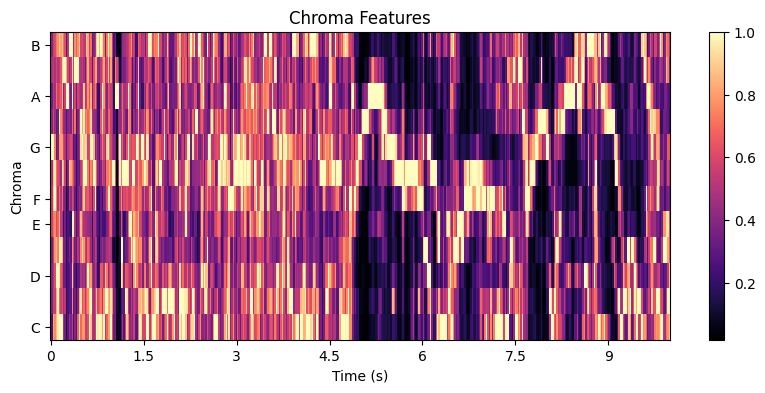

In [155]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(chroma, y_axis='chroma', x_axis='time')
plt.colorbar()
plt.title('Chroma Features')
plt.xlabel('Time (s)')
plt.ylabel('Chroma')
plt.show()

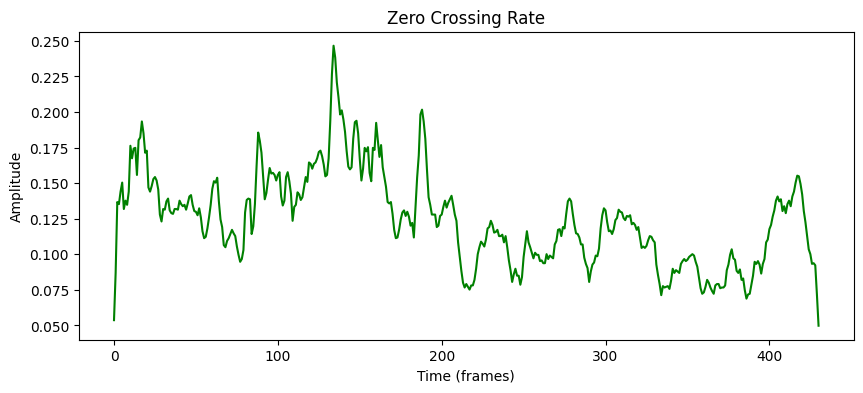

In [156]:
plt.figure(figsize=(10, 4))
plt.plot(zero_crossing_rate, color='g')
plt.title('Zero Crossing Rate')
plt.xlabel('Time (frames)')
plt.ylabel('Amplitude')
plt.show()

In [157]:
def plot_mel_spectrogram(class_name, num_samples=3):
    class_files = os.listdir(os.path.join(data_dir, class_name))
    sample_files = np.random.choice(class_files, num_samples, replace=False)
    
    plt.figure(figsize=(15, 4*num_samples))
    for i, file in enumerate(sample_files):
        audio, sr = librosa.load(os.path.join(data_dir, class_name, file))
        mel_spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
        mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)
        
        plt.subplot(num_samples, 1, i+1)
        librosa.display.specshow(mel_spectrogram_db, sr=sr, x_axis='time', y_axis='mel')
        plt.colorbar(format='%+2.0f dB')
        plt.title(f'Mel Spectrogram - {class_name} - {file}')
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
    plt.tight_layout()
    plt.show()

Mel Spectrograms for class: Elephant


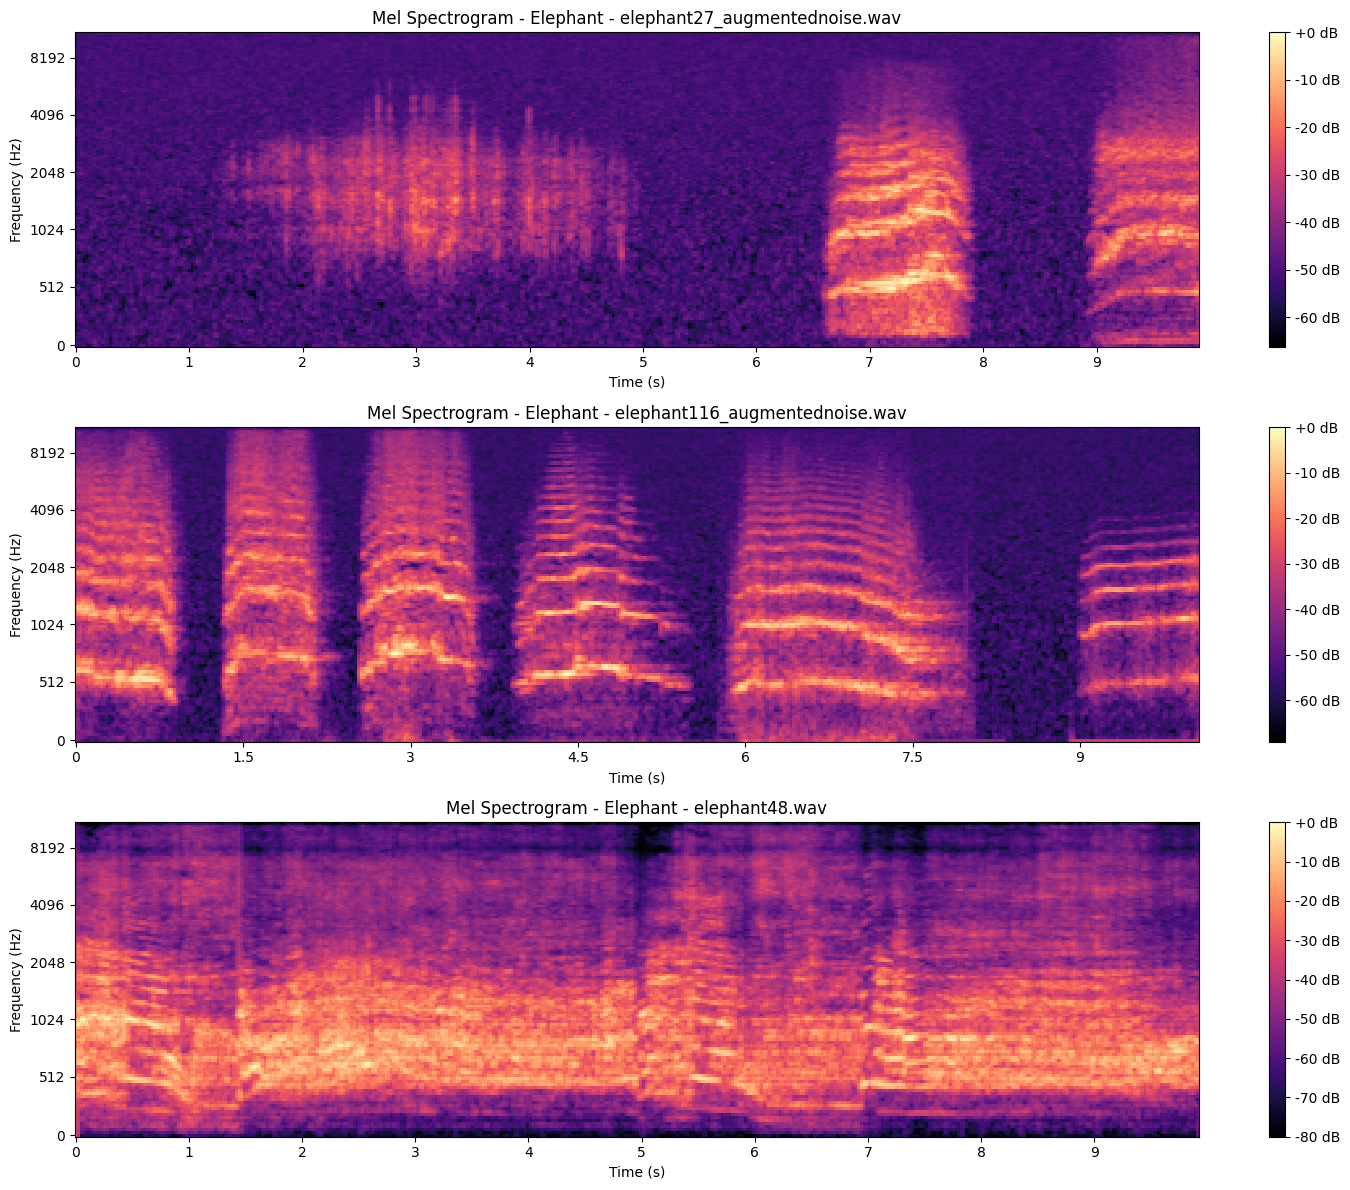

Mel Spectrograms for class: Leopard


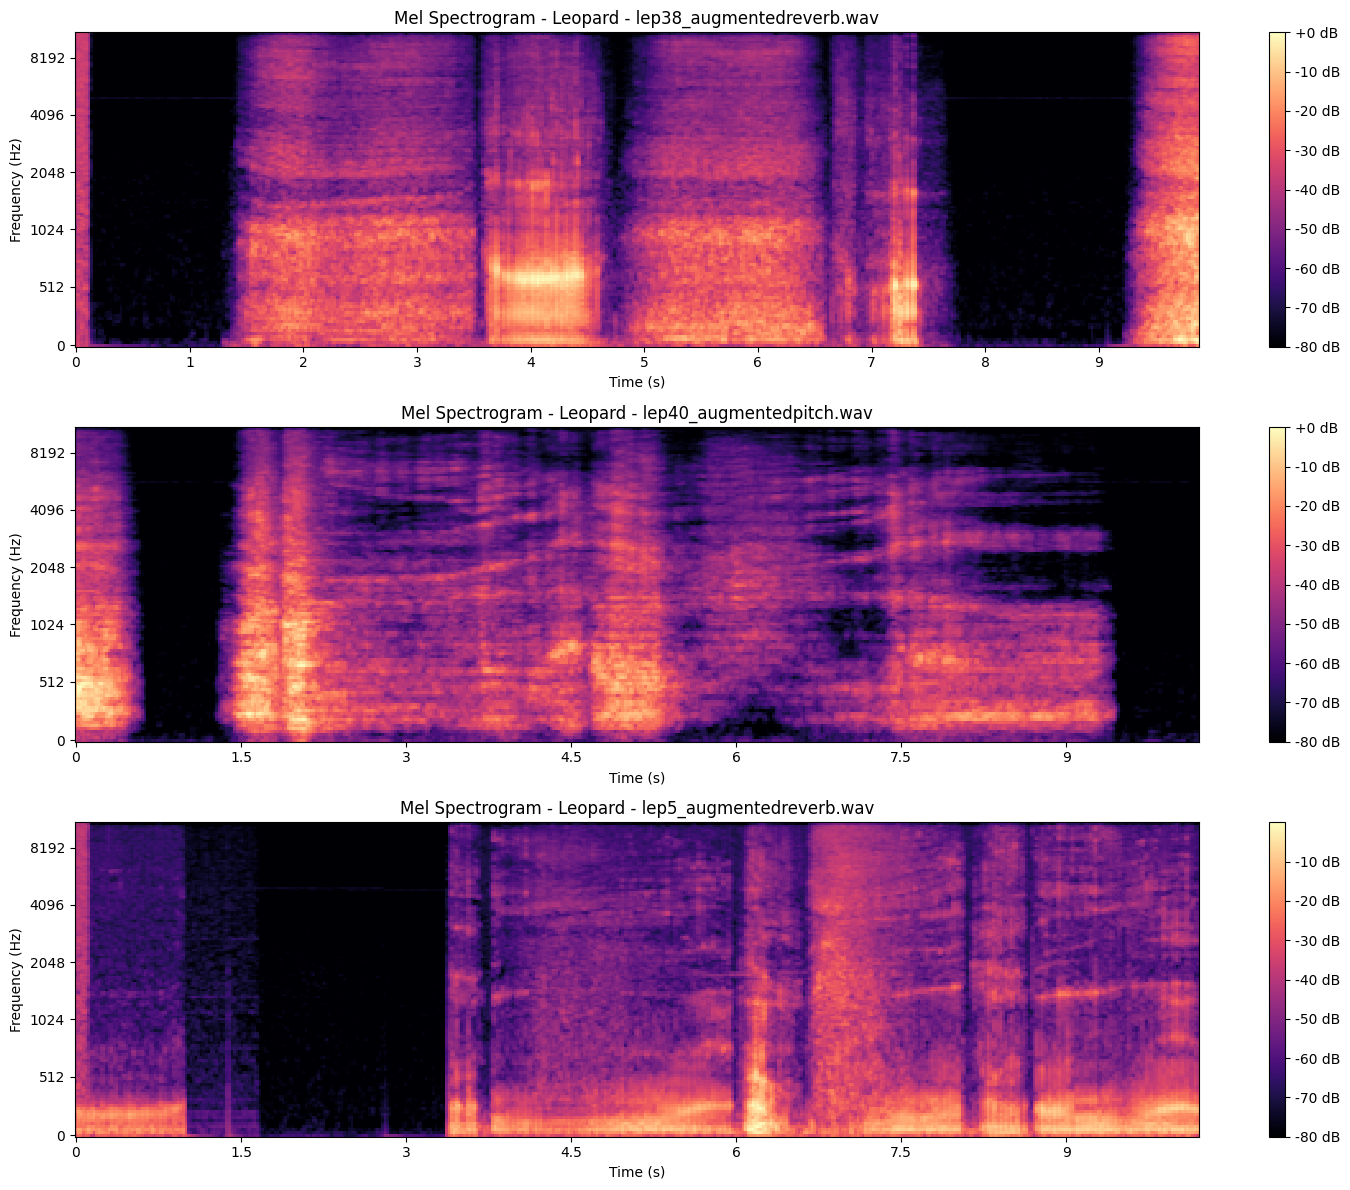

Mel Spectrograms for class: Negative


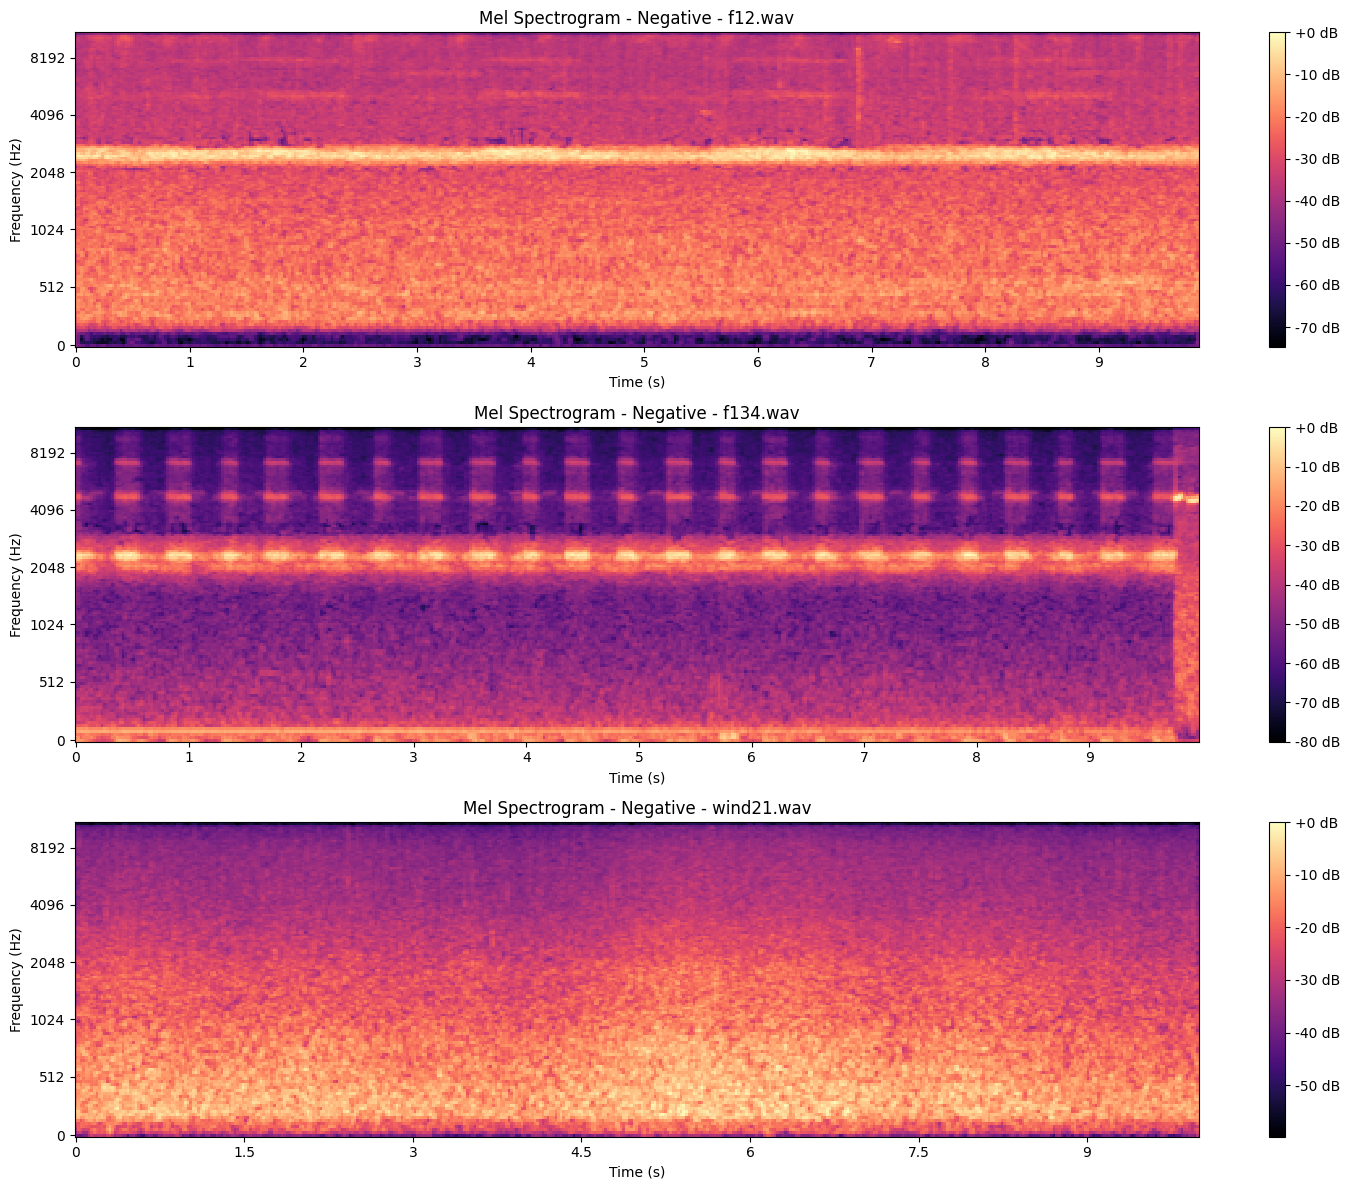

Mel Spectrograms for class: Otter


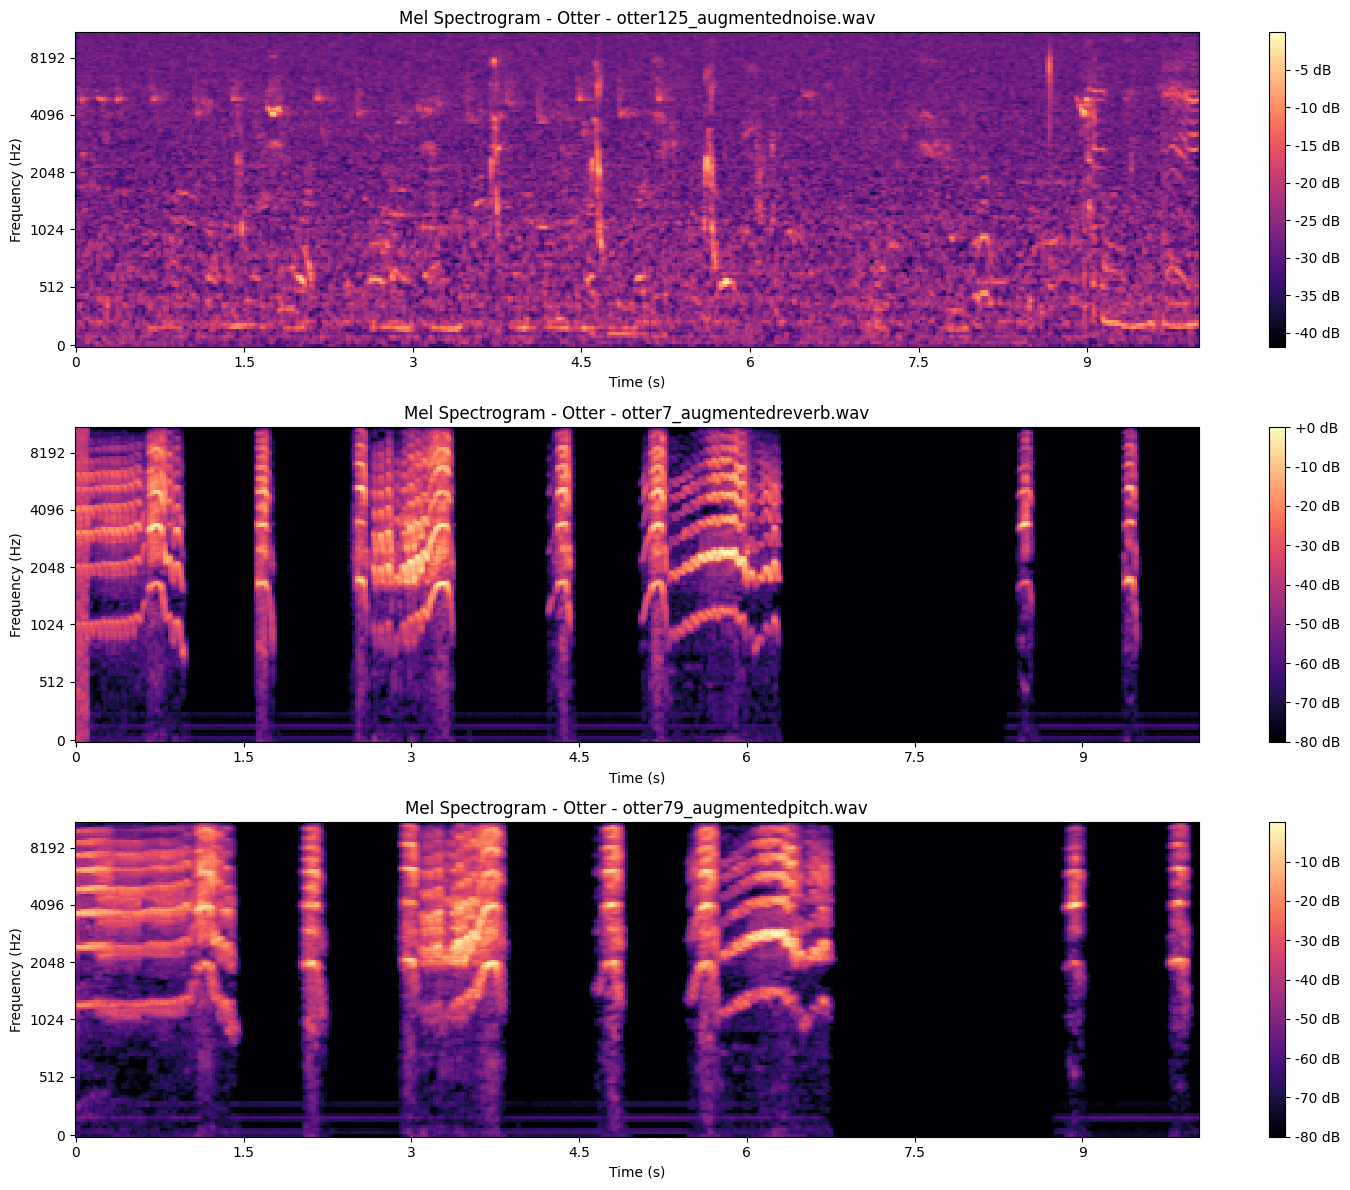

Mel Spectrograms for class: Tiger


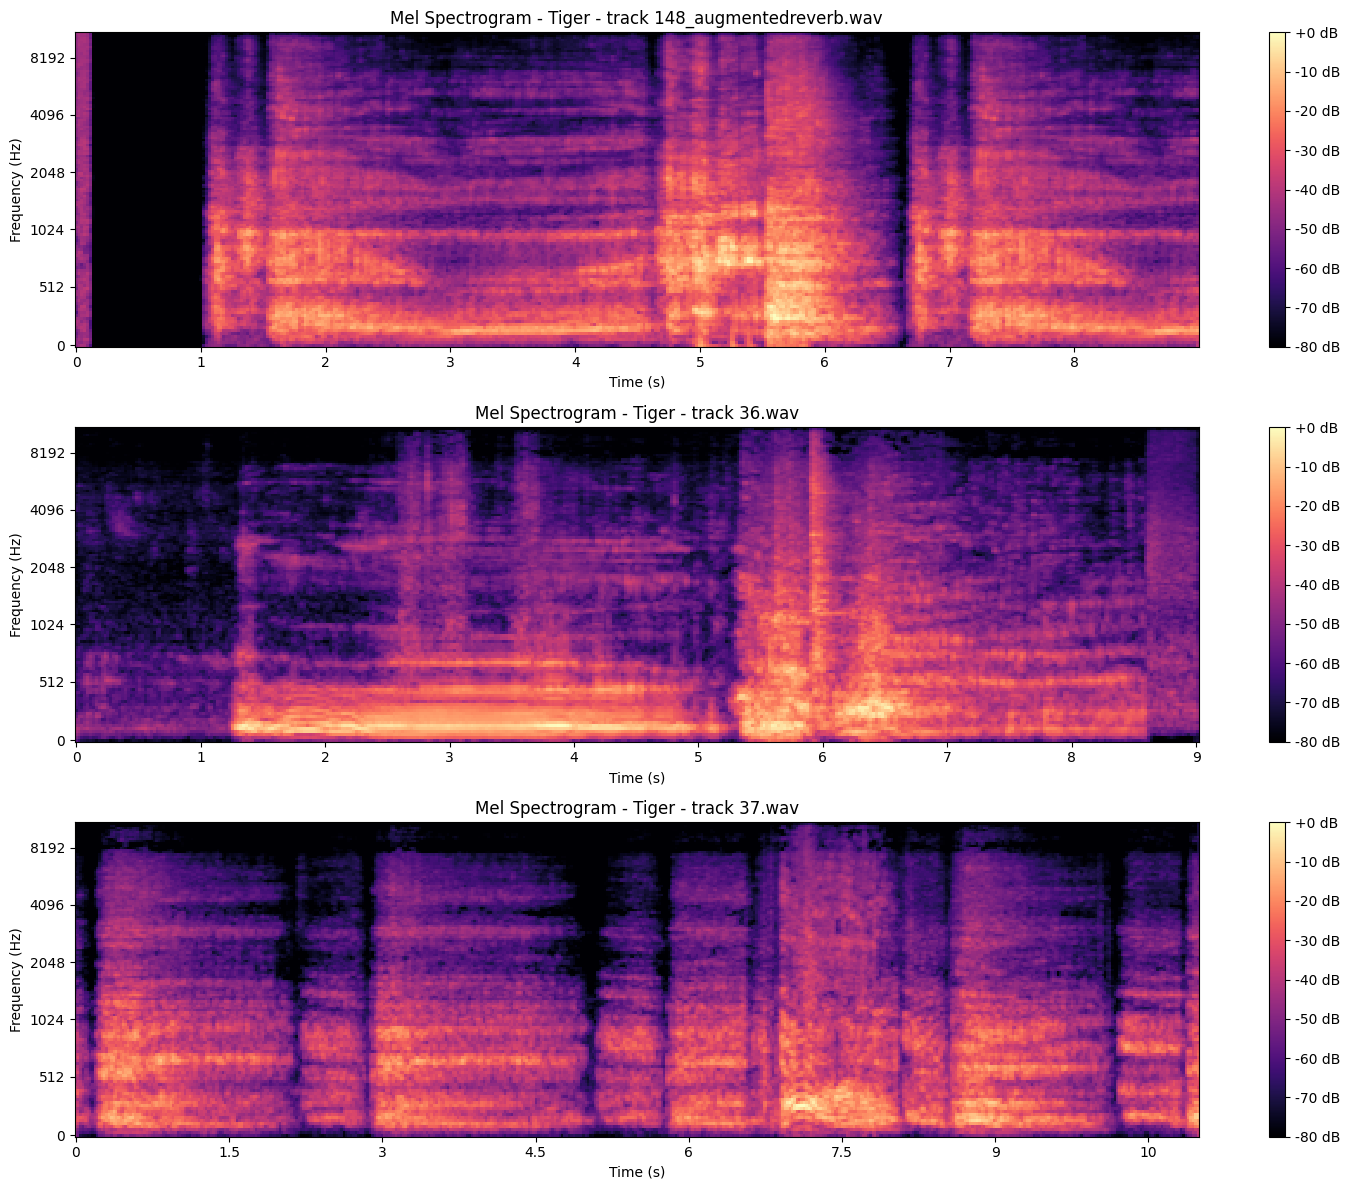

In [158]:
for class_name in classes:
    print(f"Mel Spectrograms for class: {class_name}")
    plot_mel_spectrogram(class_name)

In [159]:
features = {}
for class_name in classes:
    class_files = os.listdir(os.path.join(data_dir, class_name))
    for file in class_files:
        audio, sr = librosa.load(os.path.join(data_dir, class_name, file))
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        features[file] = mfccs.T

In [165]:
def data_generator(X_files, y_labels, batch_size=32):
    num_samples = len(X_files)
    while True:
        for offset in range(0, num_samples, batch_size):
            batch_files = X_files[offset:offset+batch_size]
            batch_features = []
            batch_labels = []
            for file, label in zip(batch_files, y_labels[offset:offset+batch_size]):
                audio, sr = librosa.load(file)
                mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
                mfccs_flat = mfccs.flatten()
                batch_features.append(mfccs_flat)
                batch_labels.append(label)
            yield np.array(batch_features), np.array(batch_labels)

In [167]:
from sklearn.model_selection import train_test_split
X_train_files, X_test_files, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Total length of the dataset:",len(features))
print("Total length of the training set:",len(X_train))
print("Total length of the testing set:",len(X_test))

Total length of the dataset: 3851
Total length of the training set: 3080
Total length of the testing set: 771


In [168]:
train_generator = data_generator(X_train_files, y_train)
test_generator = data_generator(X_test_files, y_test)

In [173]:
print("Sample X_train_files:", X_train_files[:5])
print("Sample X_test_files:", X_test_files[:5])

Sample X_train_files: [array([-1.8309607e+02, -1.4899332e+02, -1.4960768e+02, ...,
        7.8592978e+00,  6.4861774e-04,  1.1446563e+00], dtype=float32), array([-556.1269  , -585.4535  , -611.411   , ...,   15.265814,
         16.033112,   14.816982], dtype=float32), array([-81.73219 , -49.903572, -56.66622 , ..., -13.399126, -17.043005,
       -14.690095], dtype=float32), array([-272.69696   , -239.52759   , -234.50179   , ...,    0.5426072 ,
          3.1449065 ,    0.50433147], dtype=float32), array([-599.06384 , -597.77936 , -597.3987  , ...,    8.137343,
          6.057993,    3.851736], dtype=float32)]
Sample X_test_files: [array([-126.747116  ,  -79.73074   ,  -76.80016   , ...,   -2.9573536 ,
         -3.1254437 ,   -0.26574802], dtype=float32), array([-1.61995193e+02, -1.23921585e+02, -1.20913345e+02, ...,
        9.80768204e-02, -1.40494013e+00,  2.18547845e+00], dtype=float32), array([-151.38965  , -117.28568  , -116.98727  , ...,   -6.4199076,
         -5.742111 ,   -2.432

In [177]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

from tensorflow.keras.preprocessing.sequence import pad_sequences

max_length = 1000  

X_train_padded = pad_sequences(X_train_files, maxlen=max_length, dtype='float32', padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_files, maxlen=max_length, dtype='float32', padding='post', truncating='post')

rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train_padded, y_train)

y_pred = rf_classifier.predict(X_test_padded)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=classes))

Accuracy: 0.9130998702983139

Classification Report:
              precision    recall  f1-score   support

    Elephant       0.92      0.82      0.86       141
     Leopard       0.87      0.94      0.90       112
    Negative       0.88      0.90      0.89       159
       Otter       0.93      0.90      0.92       108
       Tiger       0.94      0.97      0.96       251

    accuracy                           0.91       771
   macro avg       0.91      0.90      0.91       771
weighted avg       0.91      0.91      0.91       771



In [185]:
# Loading the dataset
def load_data(dataset_path, mfcc=True):
    labels = []
    features = []
    for class_name in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_name)
        if os.path.isdir(class_path):
            for filename in os.listdir(class_path):
                file_path = os.path.join(class_path, filename)
                feature = extract_features(file_path, mfcc=mfcc)
                if feature is not None:
                    features.append(feature)
                    labels.append(class_name)
    return np.array(features), np.array(labels)

In [186]:
# extracting the features from the dataset
def extract_features(file_path, mfcc=True, n_mfcc=13, max_len=128):
    audio, _ = librosa.load(file_path, sr=22050)
    if mfcc:
        mfccs = librosa.feature.mfcc(y=audio, sr=22050, n_mfcc=n_mfcc)
        if (max_len > mfccs.shape[1]):
            pad_width = max_len - mfccs.shape[1]
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_len]
        return mfccs
    else:
        return None

In [187]:
dataset_path = "Dataset"
features, labels = load_data(dataset_path)

In [188]:
label_to_index = {label: i for i, label in enumerate(np.unique(labels))}
index_to_label = {i: label for label, i in label_to_index.items()}
labels = np.array([label_to_index[label] for label in labels])

In [189]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

print("Total length of the dataset:",len(features))
print("Total length of the training set:",len(X_train))
print("Total length of the testing set:",len(X_test))

Total length of the dataset: 3851
Total length of the training set: 3080
Total length of the testing set: 771


In [192]:
# Reshape the input data
X_train = X_train[..., np.newaxis] 
X_test = X_test[..., np.newaxis]

In [193]:
model = Sequential([
    layers.Input(shape=X_train.shape[1:]),
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(np.unique(labels)), activation='softmax')
])

In [194]:
# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [195]:
# Define callbacks
early_stopping = callbacks.EarlyStopping(patience=3, restore_best_weights=True)

In [196]:
# Train the model
history = model.fit(X_train, y_train, validation_split=0.1, epochs=20, batch_size=32, callbacks=[early_stopping])

Epoch 1/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.4937 - loss: 8.4193 - val_accuracy: 0.7695 - val_loss: 0.6761
Epoch 2/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8002 - loss: 0.5853 - val_accuracy: 0.8312 - val_loss: 0.4559
Epoch 3/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8771 - loss: 0.3898 - val_accuracy: 0.8636 - val_loss: 0.3988
Epoch 4/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9139 - loss: 0.2744 - val_accuracy: 0.8669 - val_loss: 0.3700
Epoch 5/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9329 - loss: 0.2254 - val_accuracy: 0.9026 - val_loss: 0.3235
Epoch 6/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9586 - loss: 0.1365 - val_accuracy: 0.8864 - val_loss: 0.3313
Epoch 7/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.9586 - loss: 0.1292 - val_accuracy: 0.8734 - val_loss: 0.4056
Epoch 8/20
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9537 - loss: 0.1410 - val_accuracy: 0.8831 - v

In [197]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9214 - loss: 0.2729
Test Accuracy: 0.9143968820571899


In [198]:
# Evaluate model on training data
train_loss, train_accuracy = model.evaluate(X_train, y_train)
print("Training Accuracy:", train_accuracy)

97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9663 - loss: 0.1189
Training Accuracy: 0.9597402811050415


In [200]:
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


In [201]:
predicted_labels

array([4, 0, 0, 4, 4, 4, 3, 3, 1, 1, 4, 3, 0, 3, 0, 4, 1, 3, 4, 4, 4, 0,
       4, 3, 4, 4, 0, 4, 4, 0, 4, 0, 2, 4, 0, 3, 4, 3, 1, 2, 4, 4, 1, 4,
       3, 2, 2, 2, 1, 4, 1, 3, 3, 4, 4, 4, 0, 4, 1, 2, 1, 1, 3, 4, 1, 2,
       0, 3, 3, 2, 1, 0, 1, 3, 4, 2, 3, 1, 4, 4, 2, 1, 4, 4, 0, 2, 4, 0,
       0, 3, 3, 1, 0, 2, 3, 4, 4, 3, 0, 1, 4, 2, 0, 2, 2, 1, 4, 2, 0, 4,
       3, 2, 4, 4, 4, 4, 2, 1, 0, 1, 4, 0, 4, 3, 2, 3, 0, 4, 0, 3, 4, 4,
       1, 3, 4, 1, 4, 1, 4, 1, 4, 3, 2, 4, 0, 1, 2, 4, 1, 1, 3, 3, 4, 0,
       2, 1, 4, 1, 2, 0, 1, 4, 3, 2, 4, 2, 2, 0, 3, 4, 0, 4, 1, 3, 2, 0,
       2, 4, 2, 2, 4, 0, 3, 4, 0, 1, 1, 0, 3, 0, 3, 4, 4, 4, 4, 0, 3, 4,
       4, 2, 0, 0, 0, 4, 0, 2, 4, 1, 2, 4, 1, 1, 0, 4, 4, 0, 0, 4, 1, 4,
       4, 4, 4, 2, 2, 4, 0, 4, 1, 4, 3, 1, 3, 3, 4, 2, 3, 4, 1, 4, 2, 3,
       4, 3, 0, 3, 0, 0, 4, 4, 0, 1, 0, 3, 4, 2, 3, 4, 4, 2, 0, 1, 0, 1,
       2, 1, 4, 4, 0, 4, 2, 3, 1, 0, 0, 0, 4, 0, 1, 0, 4, 1, 2, 3, 4, 2,
       4, 0, 4, 3, 2, 1, 4, 4, 2, 3, 3, 4, 0, 4, 2,

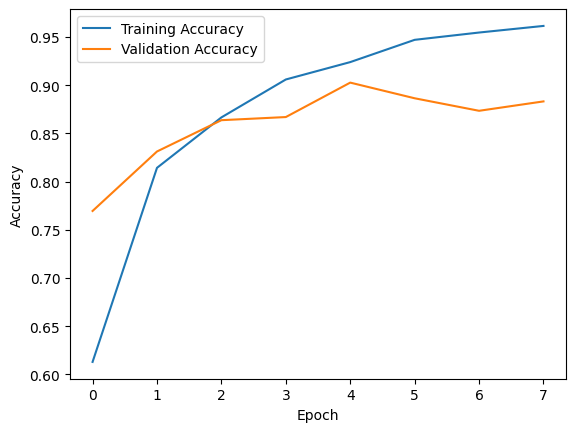

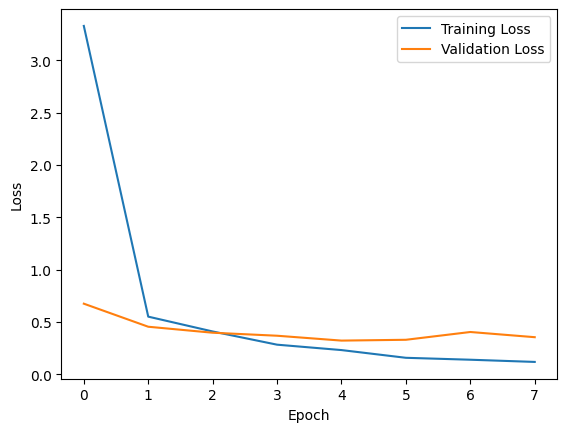

In [202]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [203]:
from sklearn.metrics import classification_report
report = classification_report(y_test, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.92      0.91      0.92       141
           1       0.87      0.96      0.91       112
           2       0.94      0.84      0.89       159
           3       0.86      0.88      0.87       108
           4       0.94      0.96      0.95       251

    accuracy                           0.91       771
   macro avg       0.91      0.91      0.91       771
weighted avg       0.92      0.91      0.91       771



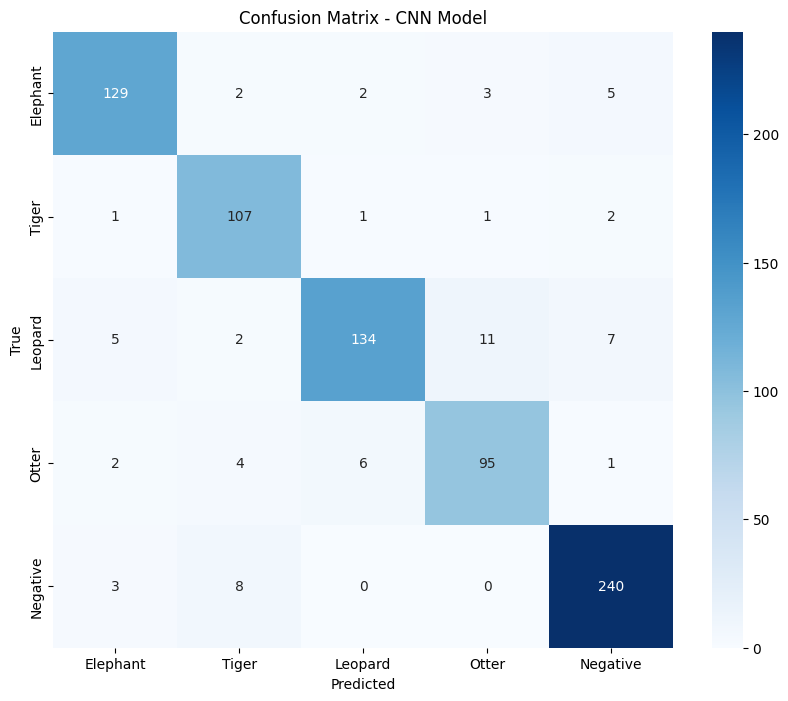

In [204]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
animals = ['Elephant', 'Tiger', 'Leopard', 'Otter', 'Negative'] 
conf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=animals, yticklabels=animals)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN Model')
plt.show()

In [205]:
model.save("audio_classifier_model.h5")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


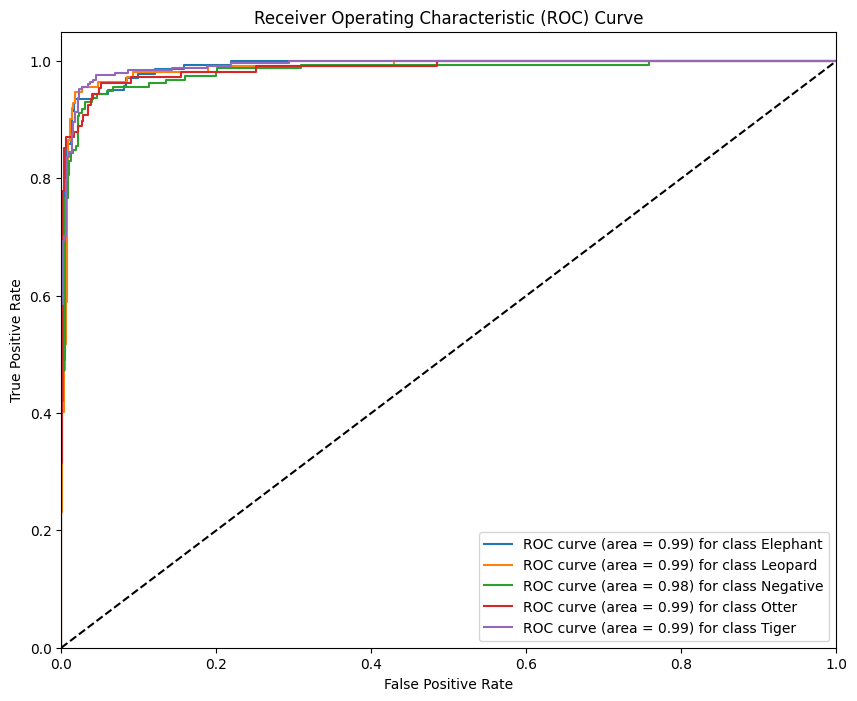

In [206]:
from sklearn.metrics import roc_curve, auc
y_pred_proba = model.predict(X_test)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(labels))):
    fpr[i], tpr[i], _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure(figsize=(10, 8))
for i in range(len(np.unique(labels))):
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for class %s' % (roc_auc[i], index_to_label[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
              precision    recall  f1-score   support

           0       0.93      0.91      0.92       141
           1       0.91      0.93      0.92       112
           2       0.94      0.84      0.89       159
           3       0.88      0.88      0.88       108
           4       0.95      0.95      0.95       251
           5       0.00      0.00      0.00         0

    accuracy                           0.91       771
   macro avg       0.77      0.75      0.76       771
weighted avg       0.93      0.91      0.92       771



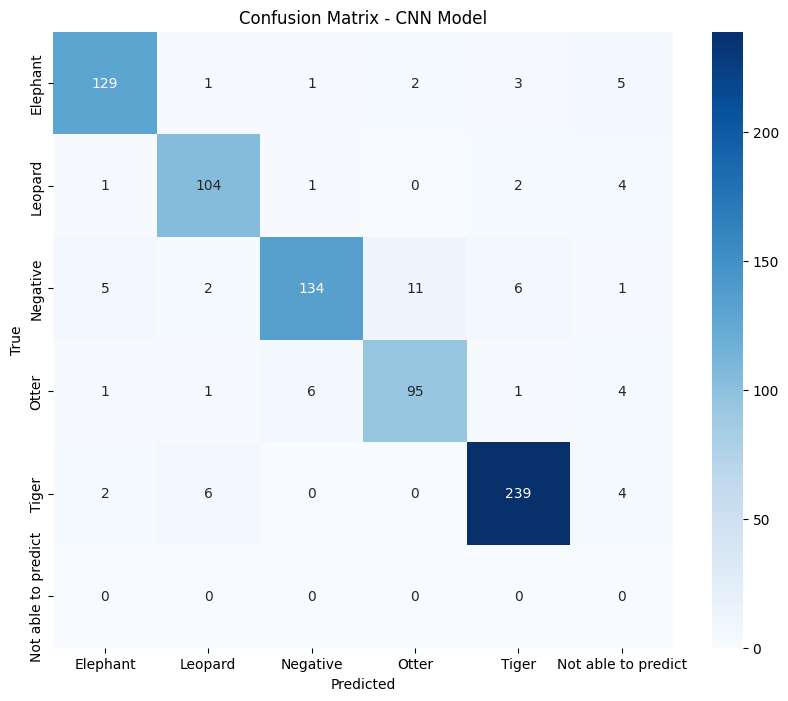

In [207]:
# Predict probabilities for test set
y_pred_proba = model.predict(X_test)

# Define a threshold for prediction probabilities
threshold = 0.5  # Adjust this threshold as needed

# Get the predicted labels based on threshold
predicted_labels = []
for prob in y_pred_proba:
    max_prob = np.max(prob)
    if max_prob < threshold:
        predicted_labels.append(len(classes))  # Assign a new label for "not able to predict"
    else:
        predicted_labels.append(np.argmax(prob))

# Convert predicted labels to class names
predicted_classes = [index_to_label[label] if label < len(classes) else "Not able to predict" for label in predicted_labels]

# Evaluate the model
report = classification_report(y_test, predicted_labels)
print(report)

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes + ['Not able to predict'], yticklabels=classes + ['Not able to predict'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - CNN Model')
plt.show()


In [211]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("audio_classifier_model.h5")

# Function to predict class of audio file
def predict_audio_class(audio_file_path):
    # Extract features from audio file
    features = extract_features(audio_file_path)
    
    if features is None:
        return "Unable to extract features from the audio file."
    
    # Preprocess the features to match the input shape expected by the model
    # (You may need to reshape or normalize the features)
    # For example, if your model expects input shape (batch_size, height, width, channels):
    # features = features.reshape((1, height, width, channels))
    features = features[np.newaxis, ..., np.newaxis]
    
    # Make predictions
    predictions = model.predict(features)
    
    # Check if the prediction confidence is below a certain threshold
    threshold = 0.5  # Adjust this threshold as needed
    if np.max(predictions) < threshold:
        return "Model confidence is below threshold. Unable to classify."
    
    # Get the predicted class
    predicted_class_index = np.argmax(predictions)
    predicted_class = index_to_label[predicted_class_index]
    
    return predicted_class

# Example usage:
audio_file_path = "a10a.mp3"
predicted_class = predict_audio_class(audio_file_path)
print("Predicted class:", predicted_class)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
Predicted class: Elephant
